In [3]:

from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
import warnings

In [4]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
warnings.filterwarnings("ignore")

In [6]:
# Load the dataset
file_path = 'creditcard.csv'
df = pd.read_csv(file_path)


In [7]:
# Assuming 'X' contains features and 'y' contains labels (fraud or not)
X = df.drop('Class', axis=1)
y = df['Class']




In [8]:
def evaluate_models(X, y, apply_smote=False):
    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize models to evaluate
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    }

    # Initialize dictionary to store metrics
    results = {model_name: {"ROC AUC": 0, "Accuracy": 0, "Confusion Matrix": None} for model_name in models}

    # Loop over each fold
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Apply SMOTE on the training data if specified
        if apply_smote:
            smote = SMOTE(random_state=42)
            X_train, y_train = smote.fit_resample(X_train, y_train)

        # Evaluate each model
        for model_name, model in models.items():
            # Fit the model
            model.fit(X_train, y_train)

            # Predict on the test set
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

            # Calculate metrics
            if y_pred_proba is not None:
                roc_auc = roc_auc_score(y_test, y_pred_proba)
            else:
                roc_auc = 0  # Not all models support predict_proba

            acc = accuracy_score(y_test, y_pred)
            conf_matrix = confusion_matrix(y_test, y_pred)

            # Update results dictionary
            results[model_name]["ROC AUC"] += roc_auc
            results[model_name]["Accuracy"] += acc
            results[model_name]["Confusion Matrix"] = conf_matrix

    # Average metrics over folds
    for model_name in results:
        results[model_name]["ROC AUC"] /= skf.get_n_splits()
        results[model_name]["Accuracy"] /= skf.get_n_splits()

    return results

In [9]:
# Evaluate models without SMOTE
results_without_smote = evaluate_models(X, y, apply_smote=False)

In [10]:
# Evaluate models with SMOTE
results_with_smote = evaluate_models(X, y, apply_smote=True)


In [11]:
# Convert results to DataFrame for better visualization
df_without_smote = pd.DataFrame(results_without_smote).T
df_with_smote = pd.DataFrame(results_with_smote).T

# Display results for comparison
print("Results Without SMOTE:")
print(df_without_smote)
print("\nResults With SMOTE:")
print(df_with_smote)

Results Without SMOTE:
                      ROC AUC  Accuracy         Confusion Matrix
Logistic Regression  0.956746  0.999238  [[56853, 10], [32, 66]]
K-Nearest Neighbors   0.60951  0.998371    [[56863, 0], [94, 4]]
Decision Tree        0.885979  0.999147  [[56828, 35], [23, 75]]
XGBoost              0.944568  0.999449  [[56848, 15], [24, 74]]

Results With SMOTE:
                      ROC AUC  Accuracy           Confusion Matrix
Logistic Regression   0.97851  0.988494   [[56272, 591], [14, 84]]
K-Nearest Neighbors  0.750299  0.946588  [[53951, 2912], [47, 51]]
Decision Tree        0.897528  0.997904   [[56763, 100], [21, 77]]
XGBoost              0.980354  0.999473    [[56845, 18], [16, 82]]


In [12]:
# training and testing sets (4:1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# Implement Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

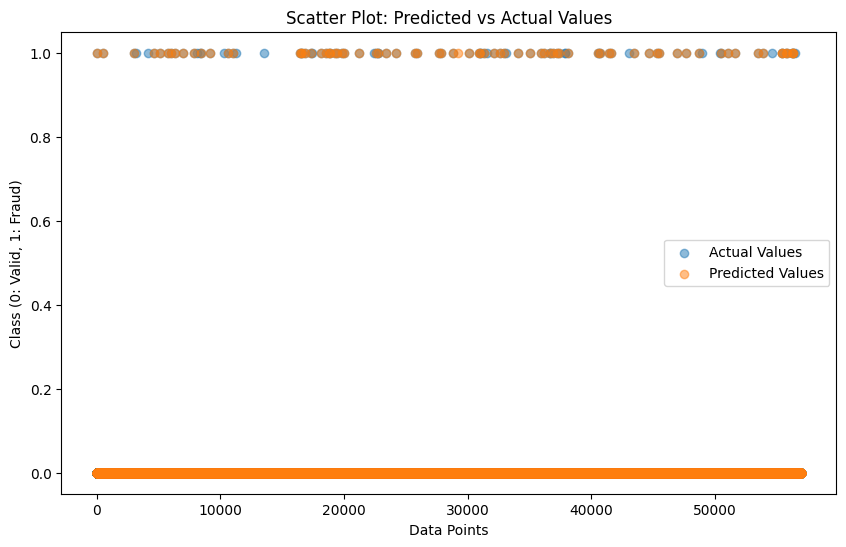

In [14]:

# Predictions
y_pred = rf_classifier.predict(X_test)

# Plot 1: Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual Values', alpha=0.5)
plt.scatter(range(len(y_test)), y_pred, label='Predicted Values', alpha=0.5)
plt.title('Scatter Plot: Predicted vs Actual Values')
plt.xlabel('Data Points')
plt.ylabel('Class (0: Valid, 1: Fraud)')
plt.legend()
plt.show()



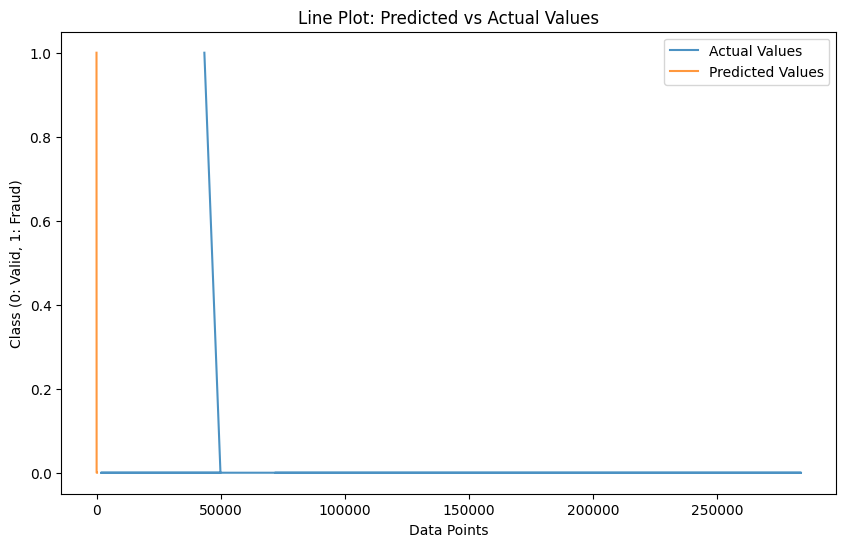

In [15]:
# Plot 2: Line plot
plt.figure(figsize=(10, 6))
plt.plot(y_test[:200], label='Actual Values', alpha=0.8)
plt.plot(y_pred[:200], label='Predicted Values', alpha=0.8)
plt.title('Line Plot: Predicted vs Actual Values')
plt.xlabel('Data Points')
plt.ylabel('Class (0: Valid, 1: Fraud)')
plt.legend()
plt.show()



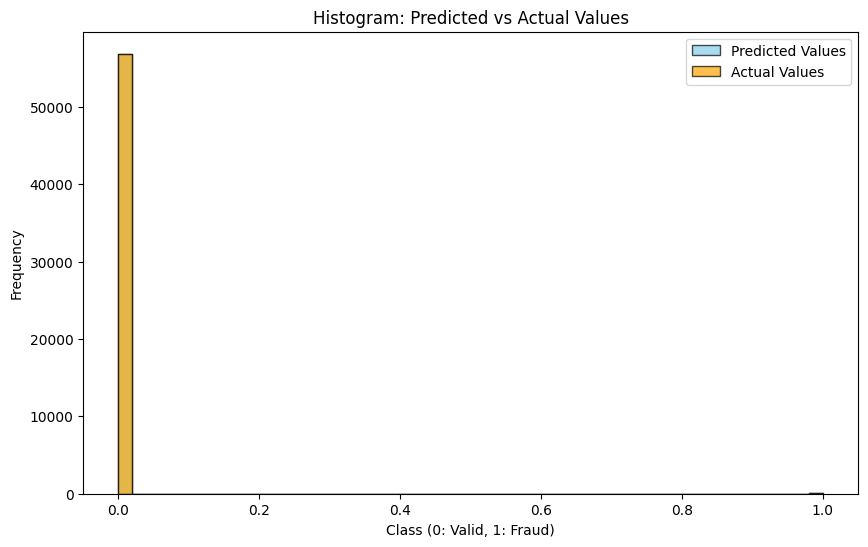

In [16]:
# Plot 3: Histogram
plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=50, color='skyblue', edgecolor='black', alpha=0.7, label='Predicted Values')
plt.hist(y_test, bins=50, color='orange', edgecolor='black', alpha=0.7, label='Actual Values')
plt.title('Histogram: Predicted vs Actual Values')
plt.xlabel('Class (0: Valid, 1: Fraud)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

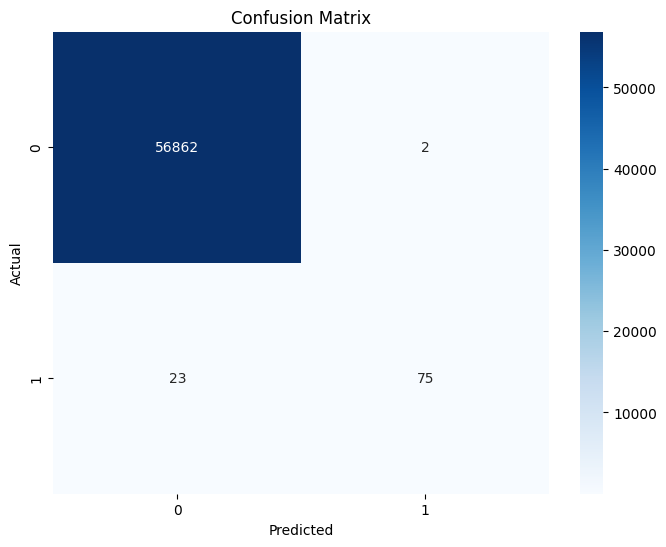

In [17]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [18]:
# Report Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')


Accuracy: 0.9996
Precision: 0.9740
Recall: 0.7653
F1-Score: 0.8571
